In [1]:
from IPython.display import Latex, Math
from IPython.display import Image

# Entry requirements

We are going to explore the entry requirements across countries in this blog post. An entry requirements range from visa free entry to being barred from a country.


## Preliminaries
### Tooling
The following toolkits and tools will be needed:

In [2]:
from collections import Counter
from itertools import chain, repeat
import json

import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, ListedColormap

import pandas as pd

import seaborn as sns

import scipy.stats as sts
import scipy.spatial.distance as ssd

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

### Utility functions 
A handful of helper functions are defined.

In [3]:
def load_dict_from_json(path_to_file):
    """
    Loads a dictionary from a json file
    Parameters:
        path_to_file (str) : **full** path to the json storage
    Returns:
        dict_ ({}) : dictionary
    """
    with open(path_to_file, 'r') as fproc:
        dict_ = json.load(fproc)
    return dict_

In [4]:
def load_df_from_json(path_to_file, orient = 'index'):
    """
    Loads a pandas dataframe from a json file.
    Parameters:
        path_to_file (str) : **full** path to the json storage
        orient (str) : orientation of the json (see pandas.read_json for details)
    Returns:
        df (pandas.DataFrame) : a dataframe
    """
    with open(path_to_file, 'r') as fproc:
        df = pd.read_json(fproc, orient = orient)        
    return df

In [5]:
def most_common(arr):
    """
    Finds the most common element in the array.
    Parameters:
        arr (iterable) : an iterable 
    Returns:
        most_common_element (object) : the most common element in the iterable. In case of ties it returns only on of them.
    """
    counter = Counter(arr)
    most_common_element = counter.most_common(1)[0][0]
    
    return most_common_element

### Coding style
I will tend to prefer a functional approach for the following reasons:

* It is concise
* It can save memory
* It reflects the transformational nature of data analysis

For example, the `most_common` function would look like 
```
most_common = lambda x: Counter(x).most_common(1)[0][0]
```

### Graphs
If the script to generate a plot is not particularly insightful it will be omitted.  

## Data collection
The data was collected from the most excellent website [passportindex.org](https://passportindex.org).

## Preparing the data

### The data

The database is loaded from a `json` storage.

In [6]:
path_to_visa_json_db = r'C:\Users\Balazs\Desktop\bhornung_movies\yemen2018\visa\visa_by_country.json'
df_visa = load_df_from_json(path_to_visa_json_db)
df_visa.head(3)

,AD,AE,AF,AG,AL,AM,AO,AR,AT,AU,...,VA,VC,VE,VN,VU,WS,YE,ZA,ZM,ZW
AD,self,visa-free,visa required,visa-free,visa-free,visa-free,visa required,visa-free,visa-free,eTA,...,visa-free,visa-free,visa-free,visa required,visa-free,visa on arrival,visa required,visa-free,visa on arrival,visa on arrival
AE,visa-free,self,visa required,visa required / e-Visa,visa-free,visa-free,visa required,visa-free,visa-free,visa required / e-Visa,...,visa-free,visa-free,visa required,visa required,visa-free,visa on arrival,visa on arrival,visa required,visa on arrival,visa on arrival
AF,visa required,visa required / e-Visa,self,visa required / e-Visa,visa required,visa required,visa required,visa required,visa required,visa required / e-Visa,...,visa required,visa-free,visa required,visa required,visa required,visa on arrival,visa required,visa required,visa required / e-Visa,visa required / e-Visa


The row indices or labels, denote the guest countries whereas the column labels index the host countries. For example, the (AD, AL) = _visa free_ entry tells us that the citizens of Andorra are granted _visa free_ entry to Albania.

### Cleaning the data

The all of the entry requirements are checked for. We are looking for 

* aliases 
* mistyped values

A quick histogram binning returns all types of entry requirements:

In [7]:
raw_requirements = Counter(np.ravel(df_visa.values))

for idx, req in enumerate(raw_requirements.most_common()):
    print("{0}\t:  {1}".format(idx, req))

0	:  ('visa required', 18396)
1	:  ('visa-free', 11990)
2	:  ('visa on arrival', 5660)
3	:  ('visa required / e-Visa', 1799)
4	:  ('visa on arrival / eVisa', 537)
5	:  ('eTA', 479)
6	:  ('self', 199)
7	:  ('visitor’s permit', 196)
8	:  ('e-Visa', 153)
9	:  ('eVisa', 100)
10	:  ('Visa waiver on arrival', 80)
11	:  ('eVistors', 5)
12	:  ('EVW', 4)
13	:  ('visa-free ', 3)


It appears electronic visa has two aliases _e-Visa_ and _eVisa_. Also, _visa free_ has a trailing space a few times. The terms _eVistors_ (sic!), _EVW_ are also curious. The following utility `find_in_df` helps us to figure out where these entries appear:

In [8]:
def find_in_df(df, value):
    idcs = []
    for col in df.columns:
        row_idcs = df[df[col] == value].index.tolist()
        idcs.extend([(idx, col) for idx in row_idcs])
    
    return idcs

In [9]:
print("Countries with 'EVW' {0}".format(find_in_df(df_visa, 'EVW')))
print("Countries with 'eVistors' {0}".format(find_in_df(df_visa, 'eVistors')))

Countries with 'EVW' [('AE', 'UK'), ('KW', 'UK'), ('OM', 'UK'), ('QA', 'UK')]
Countries with 'eVistors' [('BG', 'AU'), ('CY', 'AU'), ('CZ', 'AU'), ('HR', 'AU'), ('RO', 'AU')]


* _EVW_ is a form of ETA (ESTA for USA) thus it will be merged into that category. 
* eVistor (eVisitor if spelt correctly) is also a type of ETA so it will also be merged into that category

Looking at _Visa waiver on arrival_ and _visitor’s permit_ reveals they cover Quatar's and Seychelles' travel requirements.

In [10]:
countries = set([x[1] for x in find_in_df(df_visa, 'Visa waiver on arrival')])
print("Countries with 'Visa waiver on arrival' {0}".format(countries))

countries = set([x[1] for x in find_in_df(df_visa, 'visitor’s permit')])
print("Countries with 'visitor’s permit' {0}".format(countries))

Countries with 'Visa waiver on arrival' {'QA'}
Countries with 'visitor’s permit' {'SC'}


It is worth noting the Seychelles offers universal visa free entry, hence its entries ought to be changed to _visa free_.

The most interesting term _Visa waiver on arrival_ provided to certain national travelling to Qatar is in practice equivalent to _visa free_ travel. It will thus be relabelled as such:

In [11]:
replace_map =  {'EVW' : 'eTA',
                'eVistors' : 'eTA',
                'visa-free ' : 'visa-free', 
                'Visa waiver on arrival' : 'visa-free', 
                'visitor’s permit' : 'visa-free',
                'e-Visa': 'eVisa'}

df_visa.replace(replace_map, inplace = True);

There case where one country explicitly bars specific nationals to enter her territory is missing. These cases can be compiled from [this wikipedia site](https://en.wikipedia.org/wiki/List_of_nationalities_forbidden_at_border). The citizens are the keys the values are the lists of countries from which they are barred from in the dictionary below. (Can the reader find out which country bans Taiwan?)

In [12]:
barred_countries = {"AM" : ["AZ", "PK"],  "BD" : ["SD", "LY"], "VE" : ["US"], "TD" : ["US"],
                    "IR" : ["US", "LY"],  "LY" : ["US"], "SY" : ["US", "LY", "ML"],"YE" : ["US", "LY"],
                    "PK" : ["LY"],"SD" : ["LY"], "KP" : ["KR", "JP"],
                    "SO" : ["AU","NZ","FI", "SE", "DE", "NO", "CA", "SK", "CZ", "HU", "GR", "LU", "NL", "UK", "US"],
                    "QA" : ["LY", "AE", "SA"], "TW" : ["GE"],
                    "RK" : ["AM", "AZ", "BY", "KZ", "KG", "MD", "RU", "TJ", "TM", "UA", "UZ", "CU", "GE", "SC"],
                    "IL" : ["IR","KW","LB","LY","SA","SY","YE","IQ","MY","DZ","BD","BN","OM","PK","AE"]}

In [13]:
for guest, hosts in barred_countries.items():
    for host in hosts:
        df_visa.loc[guest, host] = 'barred'

A quick check shows all substitutions have been performed correctly.

In [14]:
requirements = Counter(np.ravel(df_visa.values))

for idx, req in enumerate(requirements.most_common()):
    print("{0}\t: {1}".format(idx, req))

0	: ('visa required', 18341)
1	: ('visa-free', 12268)
2	: ('visa on arrival', 5658)
3	: ('visa required / e-Visa', 1791)
4	: ('visa on arrival / eVisa', 537)
5	: ('eTA', 488)
6	: ('eVisa', 253)
7	: ('self', 199)
8	: ('barred', 66)


The cleaned data are then saved.

In [15]:
path_to_visa_clean_db = r'C:\Users\Balazs\Desktop\bhornung_movies\yemen2018\visa_by_country_clean.json'
df_visa.to_json(path_to_visa_clean_db, orient = 'index')

## Analysis

There is wide range of possibilities to explore. If the reader is interested in 1D statistics, such as which is the most welcoming country he is referred to the [passport.org](https://www.passportindex.org/)  website.

### Encoding

We are dealing with categorical values therefore one can assign an integer number to each category. They are also ordered, in a sense, based on how restricted the entry to a certain country. One can try to create a mapping that represents the various levels of freedom. Albeit, it will be slightly subjective.

In [16]:
requirement_order_map = {'self' : -1, 
                         'visa-free' : 0, 
                         'eTA' : 1,
                         'visa on arrival' : 2,
                         'visa on arrival / eVisa' : 3,
                         'eVisa' : 4,
                         'visa required / e-Visa' : 5,
                         'visa required' : 6, 
                         'barred' : 7}
category_lookup = dict(zip(requirement_order_map.values(), requirement_order_map.keys()))
_ = category_lookup.pop(-1)

cat_colors = ['#405da0', '#3189b2', '#45935d', '#a5ea85', '#e2f28c', '#edc968', '#bc6843', '#474543']
cat_colors_aug = ['#000000', '#405da0', '#3189b2', '#45935d', '#a5ea85', '#e2f28c', '#edc968', '#bc6843', '#474543']
cat_cmap = ListedColormap(cat_colors)
cat_cmap_aug = ListedColormap(cat_colors_aug)

This mapping is applied to the clean database:

In [17]:
path_to_visa_clean_db = r'C:\Users\Balazs\Desktop\bhornung_movies\yemen2018\visa_by_country_clean.json'
df_visa_clean = load_df_from_json(path_to_visa_clean_db)
df_visa_clean.replace(requirement_order_map, inplace = True)

Fianlly, two lookup tables are generated to facilitate to match the country labels and names to to the indices:

In [18]:
cnt_code_lookup = dict(enumerate(df_visa_clean.index)) # index --> country code

code_name_dict = load_dict_from_json(r'C:\Users\Balazs\Desktop\bhornung_movies\yemen2018\visa\ccodes.json')
cnt_name_lookup = {_k : code_name_dict[_v] for _k, _v in cnt_code_lookup.items()} # index --> country name

### Terminology

It is worth introducing the following terminology and notation.

* The number of countries is denoted by $n_{g}$ (_g_ refers to _guest_)
* The entry requirements are categories hence the full set of them is denoted by

   $C \text{, where } C =\bigcup\limits_{k=0} c_{k}$ where $c_{i}$ is an entry category such as _visa free_.

* The table containing the entry requirements is called _voting table_ and is denoted by 

    $V \in C^{n_{g} \times n_{g}}  \iff V_{ij} \in C$, where the first index, $i$, in the guest country the second index, $j$, is the host country. $V$ is symmetric only if each pair of countries have reciprocally identical entry requirements.
   
* The _i_-th row of $V$ is denoted by $v_{i,*}$ which represents the entry requriments for a citizen of country _i_. Likewise,
* The _i_-th column of $V$ is denoted by $v_{*,i}$ which represents requirements demanded by country _j_  

In [19]:
V = df_visa_clean.values
ng = V.shape[0]
nc = len(requirement_order_map) - 1 # ignore `self`

### General observations

The entropy, $H$ measures the information content or randomness of a distribution. The higher it is the less likely one can predict which value will be observed next from the distribution of interest. Entropy has a lower bound of zero, however, in general it does not have a constant upper bound. The entropy of the distribution of categories is
$$
H(C) = \sum\limits_{i=1}^{|C|} - p(c_{i}) \log(p(c_{i})) \text{,  where}
$$
$p$ is the probabiblity density function of $C$.

Should all countries have random requirements, the entropy would be maximal for the entire table and all countries too:
$$
    H_{max}(C) = \sum\limits_{i}^{|C|} - \frac{1}{|C|} \log\frac{1}{|C|} = - log(|C|).
$$

The relative overall entropy: $H_{t} = H(V) / H_{max}(C)$ 

relative guest entropy: $H_{g}(i) = H(v_{i,*}) / H_{max}(C)$ 

relative host entropy:  $H_{h}(i)= H(v_{*,i}) / H_{max}(C)$ are defined to investigate the diversity of distribution.

In [20]:
max_entropy = np.log2(nc)
get_frequencies = lambda x: np.unique(x[x != -1], return_counts = True)[1]

# all countries
overall_entropy = sts.entropy(get_frequencies(V)) / max_entropy

# guest countries
guest_entropy = np.fromiter((sts.entropy(get_frequencies(g)) for g in V), dtype = np.float, count = ng) / max_entropy

# host countries
host_entropy = np.fromiter((sts.entropy(get_frequencies(h)) for h in V.T), dtype = np.float, count = ng) / max_entropy

print("Entropy of requirements for all countries: {0:5.3f}".format(overall_entropy))

Entropy of requirements for all countries: 0.431


The joint distribution of the two entropies are shown below. (I prefer to use scatter plot along with kde-type plots as the latter ones can be misleading sometimes, especially violin plots.)

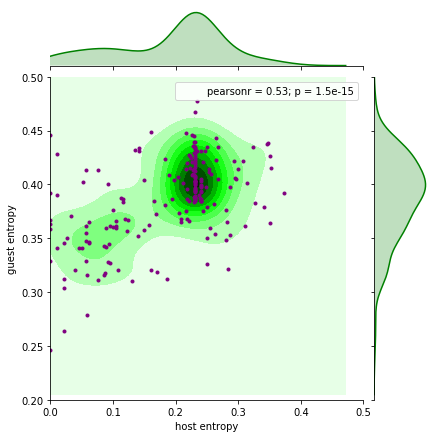

In [21]:
ax = sns.jointplot(host_entropy, guest_entropy, kind = 'kde', color = 'green', xlim = (0.0, 0.5), ylim = (0.2, 0.5))
ax.x = host_entropy; ax.y = guest_entropy;
ax.set_axis_labels("host entropy", "guest entropy")
ax.plot_joint(plt.scatter, marker = '.', c = 'purple')
plt.show()

It is immediately seen that countries do not have random requirements, for the maximum entropy is around 0.4. On the contrary, each country is biased towards certain requirements. The guest entropy never hits its lower bound, indicating each country has at least two exit requirements. The countries whose host requirement is zero demand the same documents from all incoming citizens. There are around ten of them. However, the entropy _does not_ state anything about the _values_ of the random variate. A quick sorting (pun intended) tells which ones these are.

The statistics of the countries will be collected in the `df_cnt_stats` dataframe.

In [22]:
df_cnt_stats = pd.DataFrame({'code' : df_visa_clean.index})
df_cnt_stats['name'] = df_cnt_stats['code'].apply(lambda x: code_name_dict[x])
df_cnt_stats['guest_entropy'] = guest_entropy
df_cnt_stats[ 'host_entropy'] = host_entropy
df_cnt_stats['most_common_entry'] = [category_lookup[most_common(h)] for h in V.T]
df_cnt_stats['most_common_exit'] = [category_lookup[most_common(g)] for g in V]

In [23]:
# there is a weird bug in nsmallest and nlargest so we use sort_values instead
df_cnt_stats.sort_values(by=['host_entropy'])[['name', 'host_entropy', 'most_common_entry']].head(10) 

,name,host_entropy,most_common_entry
57,MICRONESIA,0.000000,visa-free
111,MADAGASCAR,0.000000,visa on arrival
2,AFGHANISTAN,0.000000,visa required
121,MALDIVES,0.000000,visa on arrival
92,NORTH KOREA,0.000000,visa required
90,COMOROS,0.000000,visa on arrival
163,SOMALIA,0.000000,visa on arrival
44,DJIBOUTI,0.010582,visa on arrival
46,DOMINICA,0.010582,visa-free
154,SEYCHELLES,0.010582,visa-free


Indeed, uniform requirement for a country does not mean identical requirements across countries as we can see _visa free_, _visa required_ and other categories. 

### Distribution of requirements

#### Host and guest scores

A crude estimation of how welcoming a country can be expressed as the mean of the her entry requirements. This will be called the _host score_, $s_{w}$.

$$
s_{h}(i) = \frac{ \sum\limits_{j \neq i} v_{ji} } {n_{g} - 1}
$$
Likewise, the average of the exit requirements of a country will be called the guest score, $s_{g}$ and indicates how welcomed the citizens of that country are.
$$
s_{g}(i) = \frac{ \sum\limits_{j \neq i} v_{ij} } {n_{g} - 1}
$$

In [24]:
sh = (V.sum(axis = 0) + 1) / (ng - 1)
sg = (V.sum(axis = 1) + 1) / (ng - 1)

The score distribution is shown below. 

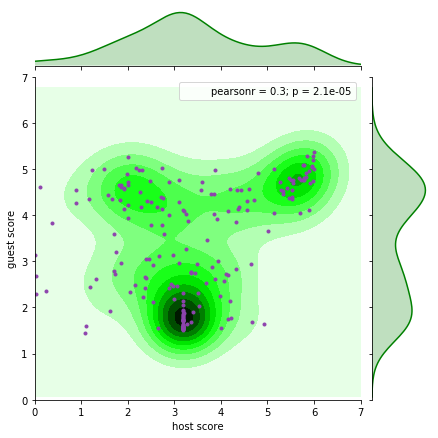

In [25]:
ax = sns.jointplot(sh, sg, kind = 'kde', color = 'green', xlim = (0.0, 7.0), ylim = (0.0, 7.0))
ax.x = sh; ax.y = sg;
ax.set_axis_labels("host score", "guest score")
ax.plot_joint(plt.scatter, marker = '.', c = '#8E44AD')
plt.show()

The histogram of the host and guest score plot hints at three major types of mutual relationships. Agglomerate of countries in the upper right corner indicates mutally restricted entry criteria. The bottom middle region of the graph groups countries that have mixed entry requirements but, in general, can enter other countries reasonbly easily. The top left cluster represents welcoming countries whose citizens face strict entry requirements. 

### Distribution of requirements

The distribution of entry requirements, $\mathbf{p}_{h}(i) \in \mathbb{R}^{n_{g} \times |C|}$, _i.e._ histogram of the columns reflects how permissive a country is.

$$
p_{h}(i)_{j} = \frac{ \sum\limits_{ k\neq i} \delta(v_{ki}, c_{j}) } {n_{g} - 1 }
$$

In [26]:
ph = np.zeros((ng, nc))
count_gen = (np.unique(v, return_counts = True) for v in V)

for row, (idcs, count) in zip(ph, count_gen): # blessed be passing references
    row[idcs[:-1]] = count[:-1]
    
ph = ph / ph.sum(axis = 1)[:, None]

The distributions for Azerbaijan, Central African Republic, Cameroon, Cape Verde, Bhutan, Congo, Belgium and The Netherlands are show below. It is readily observed the first six countries are more strict as to how much paperwork is needed to visit them compared to the last two ones. A question then naturally arises whether are there groups of countries that similar requrement patterns?

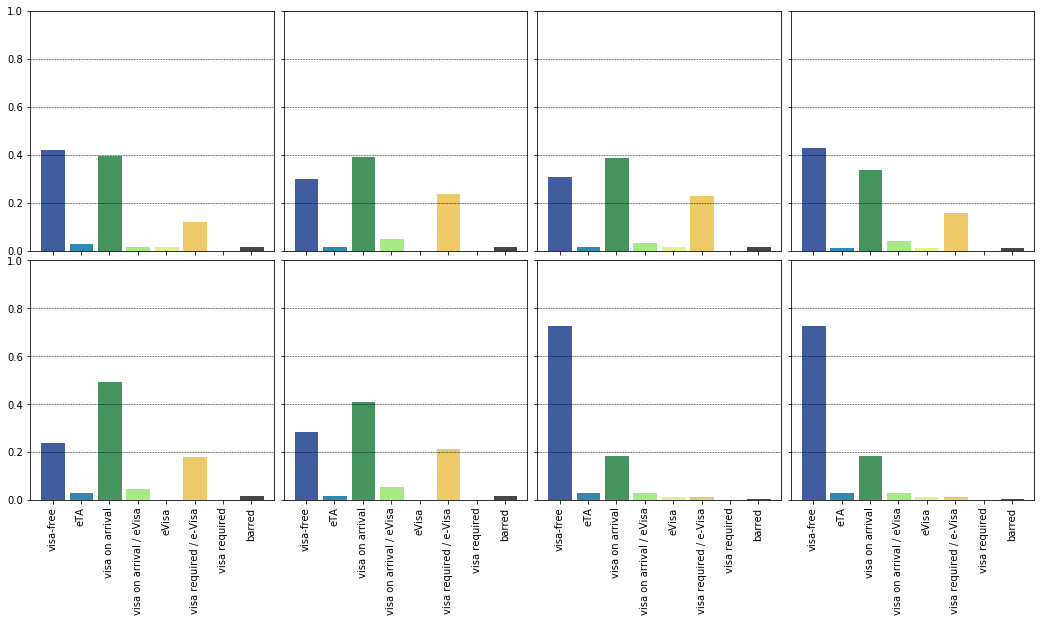

In [27]:
sel = [10, 30, 35, 40, 24, 29, 14, 130]

fig, axes = plt.subplots(2,4, sharex = True, sharey = True, gridspec_kw = {'hspace' : 0.04, 'wspace' : 0.04})
fig.set_size_inches(18,9)
for ax, idx in zip(axes.flat, sel):
    
    ax.bar(range(nc), ph[idx], label = cnt_name_lookup[idx])
    blist = ax.bar(range(len(ph[idx])), ph[idx])
    for idx, bar in enumerate(blist):
        bar.set_color(cat_colors[idx])    
    
    ax.set_ylim((0,1))
    ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)

    ax.set_xticks(range(nc))
    ax.set_xticklabels(category_lookup.values(), rotation = 90)
    
plt.show()

We can now easily figure out which country has the most polar exit requirements. Polar well separated bimodal distribution:

* there are two categories that are more likely than any other $\forall m \in C / \{k, l\} : p_{h}(i)_{k/l} > p_{h}(i)_{m} $
* their probabilities are close to each other: $p_{h}(i)_{k} \approx p_{h}(i)_{l}$
* their separation is larger than half of the cardinality of the categories: $|k - l| \geq \frac{|C|}{2}$

A limiting case is where two categories have 0.5 and 0.5 probabilties. Based on the previous plots these categories are likely to be _visa free_, _visa on arrival_ and _visa required_.

In [28]:
mask = np.zeros((3, nc), dtype = np.float)
mask[0,0] = mask[0,6] = 0.5           # visa free -- visa required
mask[1,0] = mask[1,2] = 0.5           # visa free -- visa on arrival
mask[2,2] = mask[2,6] = 0.5           # visa on arrival -- visa required
overlap = np.linalg.norm(ph[:,None,:] - mask, axis = 2)
bimodals = np.array([np.argsort(x)[:3] for x in overlap.T])

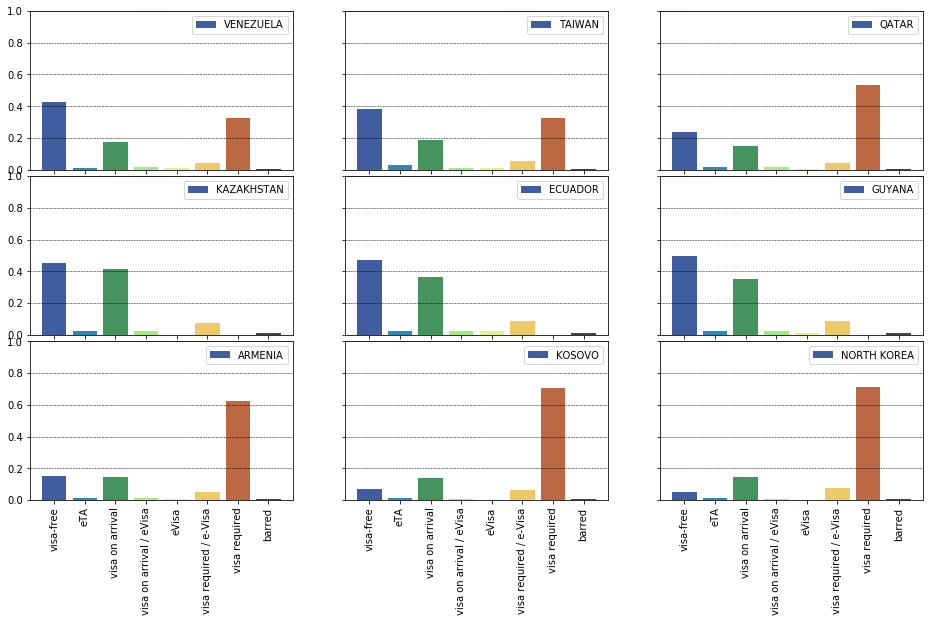

In [29]:
fig, axes = plt.subplots(3, 3, sharex = True, sharey = True, gridspec_kw = {'hspace' : 0.04})
fig.set_size_inches(16,9)
for idx, ax in zip(bimodals.flat, axes.flat):

    ax.bar(range(nc), ph[idx], color = cat_colors, label = cnt_name_lookup[idx])
    ax.set_ylim((0,1))
    ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
#
    ax.set_xticks(range(nc))
    ax.set_xticklabels(category_lookup.values(), rotation = 90)
    ax.legend()
plt.show()

### Comparison of requirements 

The entry distributions of the countries are compared _via_ the Euclidean distance matrix, $D \in \mathcal{R}^{n_{g}\times n_{g}}$.
$$
d_{ij} = \| \mathbf{p}_{h}(i) - \mathbf{p}_{h}(j) \|^{2}_{2}
$$

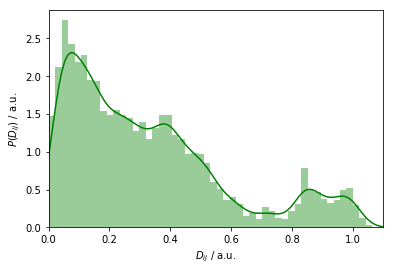

In [30]:
dist_mat = ssd.squareform(ssd.pdist(ph))

ax = sns.distplot(dist_mat.flat, kde = True, color = 'green')
ax.set_xlim((0.0, 1.1))
ax.set_xlabel(r'$D_{ij}$ / a.u.')
ax.set_ylabel(r'$P(D_{ij})$ / a.u.')
plt.show()

If  there are $n$ clusters of similar $P_{g}$-s, then the maximum number of peaks in the distance plot is 
$
\begin{equation}
    \begin{pmatrix}
          n \\
          2
    \end{pmatrix}
     + 1
\end{equation}
$.
There are about between 4 and  7 peaks in the plot above. This implies the number of clusters is 3 or 4. However, one cannot tell the which countries are in a certain cluster. In order to reveal this, we will group the $P_{g}(i)$ distributions for all countries. Firstly, we calculate the [Ward linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) between the individual distributions. The number of clusters is then chosen. The following options are given:

1. Perform a number of consecutive clusterings then choose the one where the _intra_ cluster variance is below a certain limit with the maximum number of clusters.
1. Calculate the linkage matrix, $Z$ and plot the _inter_ cluster distance. The number of subgraphs to keep is deduced by the location from the largest gap between the successive _inter_ cluster distances (see below).
1. Calculate the linkage matrix and calculate the _intra_ cluster distance in a breadth first traversal. Stop the traversal when the distance drops below a certain limit. This would save us from the computational burden of performing consecutive clustering thus assembling the same linkage matrix over and over again. 

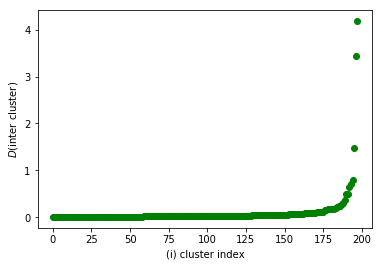

In [31]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(ph, 'ward')
plt.scatter(range(Z.shape[0]),Z[:,2], c = 'green')
plt.xlabel('(i) cluster index')
plt.ylabel(r'$D$(inter cluster)')
plt.show()

In the plot above each point corresponds to a merge. We will choose method \#1 for I am tired. The largest gap is between the penultimate point and the one before it, thus we will have three clusters. The following steps 

In [32]:
def split_at_n_top(X, n):
 
    if n == 0:
        raise ValueError("Number of clusters must be positive. Got: {0}".format(n))
    elif n == 1:
        clusters = {0 : np.arange(X.shape[0] + 1)}
        return clusters
    
# arithmetics
    n_leaves = X.shape[0] + 1              # number of leaves
    n_keep_levels = n  - 1                 # boo
    idx_max = 2 * X.shape[0] + 1           # maximum cluster index
    
# choose topmost n merges
    idcs = {int(x) for x in np.ravel(X[-n_keep_levels:, :2])}

# remove those cluster indices which are split
    split_cluster_idcs = set(range(idx_max - n_keep_levels, idx_max))
    
# remove leaves
    root_node_idcs = list(filter(lambda x: x >= n_leaves, idcs - split_cluster_idcs))
    leaf_nodes = list(filter(lambda x: x < n_leaves, idcs - split_cluster_idcs))

    # traverse all subgraphs
    clusters = {}
    
    arr_selector = lambda x, cond, arr1, arr2: arr1.append(x) if cond else arr2.append(x)
    
    for cluster_idx, root_node_idx in enumerate(root_node_idcs):
        queue, leaves = [], []
        queue.append(root_node_idx)
   
        while len(queue) > 0:
            curr = queue.pop(0)

            cl = int(X[curr - n_leaves, 0])
            cr = int(X[curr - n_leaves, 1])

            arr_selector(cl, cl >= n_leaves, queue, leaves)
            arr_selector(cr, cr >= n_leaves, queue, leaves)
         
        clusters.update({cluster_idx : np.array(leaves, dtype = np.int)})
        
    # add singleton clusters
    for idx, node in enumerate(leaf_nodes):
        idx_ = idx + cluster_idx + 1
        clusters.update({idx_ : np.array([node])})
        
    return clusters

In [33]:
def clusters_to_labels(clusters):
    """
    
    """
    n_points = sum(map(lambda x: x.size, clusters.values()))
    labels = np.zeros(n_points, dtype = np.int)
    
    for cluster_idx, idcs in clusters.items():
        labels[idcs] = cluster_idx
        
    return labels

In [34]:
def linkage_to_labels(X, n):
    """
    
    """
    clusters = split_at_n_top(X, n)
    labels = clusters_to_labels(clusters)
    return labels

In [35]:
clustaz = split_at_n_top(Z, 3)

In [36]:
means = np.array([np.mean(ph[v], axis = 0) for k, v in clustaz.items()])
stds = np.array([np.std(ph[v], axis = 0) for k, v in clustaz.items()])

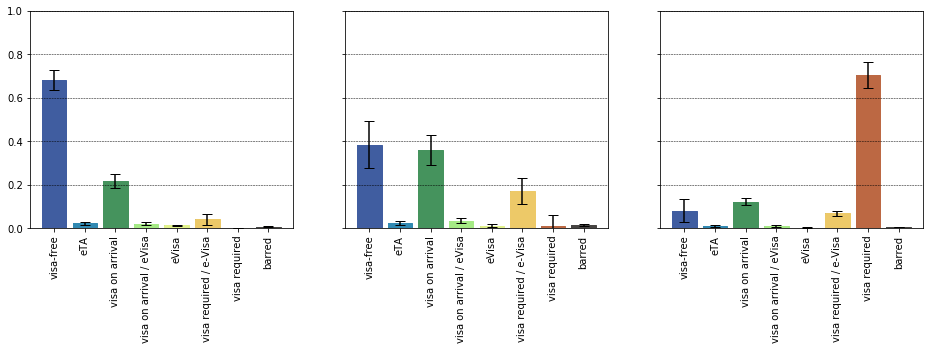

In [37]:
fig, axes = plt.subplots(1, 3, sharey = True)
fig.set_size_inches(16,4)
for mean, std, ax in zip(means, stds, axes.flat):
    
    ax.bar(range(mean.shape[0]), mean, yerr = std, capsize = 5)
    ax.set_ylim((0,1))
    ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)

    ax.set_xticks(range(8))
    ax.set_xticklabels(category_lookup.values(), rotation = 90)
    blist = ax.bar(range(len(mean)), mean)
    for idx, bar in enumerate(blist):
        bar.set_color(cat_colors[idx])
 
plt.show()

![title](02_mytree.png)

### Mutual requirements

Firstly, we investigate the reciprocity of entry requriments. To this end we pair, the $i \rightarrow j$ and $j \rightarrow i$ requirements and make a histogram of them. The resulting matrix is called reciprocity matrix, $R$:

$$
\begin{eqnarray}
R & \in & \mathbb{N}^{|C| \times |C|} \\
r_{ij} & = & \sum\limits_{k<l} \delta(v_{kl}, c_{i}) \cdot \delta(v_{lk}, c_{j})
\end{eqnarray}
$$

In [38]:
tril = chain(*map(lambda x: zip(repeat(x-1, x), range(x)), range(ng, 1, -1)))  # generator for lower triangle indices
recip_histo = Counter(map(lambda x: (V[x[1], x[0]], V[x[0], x[1]]), tril))            # count tuples

recip_mat = np.zeros((nc, nc), dtype = np.float)                                      # convert to np.ndarray
for idcs, count in recip_histo.items():
    recip_mat[idcs] = count 

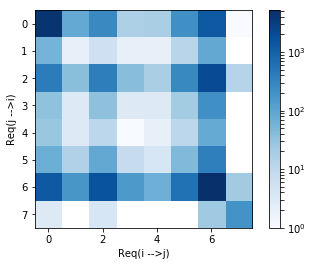

In [39]:
plt.imshow(recip_mat, cmap = 'Blues', norm = LogNorm(vmin = 1))
plt.colorbar()
plt.xlabel("Req(i -->j)"); plt.ylabel("Req(j -->i)");
plt.show()

The matrix is not symmetric meaning that there are pairs of countries in where the two parties demand different travel documents. 

* **(0,0)** is the number of cases where entry from _i_ to _j_ is _visa free_ and entry from _j_ to _i_ is _visa free_ too
* **(0,6)** is the number of cases where entry from _i_ to _j_ is _visa free_ and entry from _j_ to _i_ _requires a visa_
* likevise **(6,0)** is the number of cases where entry from _i_ to _j_ _requires a visa_ and entry from _j_ to _i_ is _visa free_
* **(2,6)** and **(6,2)** are popular categories where _visa on arrival_ is expected for a _visa_ 

The ratio of the identical requirements, `r_req_iden` is the trace of the matrix.

In [40]:
r_req_iden = np.trace(recip_mat) / np.sum(recip_mat) 
print("Ratio of mutually identical entry requirements: {0:.4f}".format(r_req_iden))

Ratio of mutually identical entry requirements: 0.4997


#### Comparing countries by reciprocity patterns

In oder to compare individual countries their reciprocity matrices, $R^{(k)} \in \mathbb{R}^{n_{c} \times n_{c}}$, have to be calculated.

$$
r^{(i)}_{kl} = \frac{ \sum\limits_{j \neq i} \delta(c_{k},v_{ij}) \cdot \delta(c_{l}, v_{ji})} {n_{g} - 1}
$$

The reciprocity matrix, $R$ defined earlier is the sum of the individual reciprocity matrices:

$$
    R = \sum\limits_{i} R^{(i)}
$$

A few lines below conveniently do this job:

In [41]:
cnt_recip_mat = np.zeros((ng, nc, nc), dtype = np.float)

for idx, (g, h) in enumerate(zip(V, V.T)):                         # make pairs
    count_dict = dict(Counter(zip(g, h)))                          # count pairs of requirements
    _ = count_dict.pop((-1, -1), None)                             # remove (-1, -1) if present
                                                        
    for (r, c), count in count_dict.items():                       # populate matrix
        cnt_recip_mat[idx, r, c] = count

cnt_recip_mat = np.reshape(cnt_recip_mat, (ng, nc * nc))
normalize(cnt_recip_mat, norm = 'l1', axis = 1, copy = False);

The most common way to identify repeating patterns is to perform a PCA analysis. There are, however, two issues with PCA. Firstly, it only accounts for linear dependencies, secondly it only looks at linear transformation of the data. Nevertheless, it produces pretty images.

In [42]:
pca = PCA();
pca.fit(cnt_recip_mat)
evr = pca.explained_variance_ratio_
cevr = np.cumsum(evr)

We are going to the first few principal components that account for the 95% of the total variance.

In [43]:
keep_idcs = np.arange(64, dtype = np.int)[cevr < 0.95]
print(keep_idcs)

[0 1 2 3 4 5]


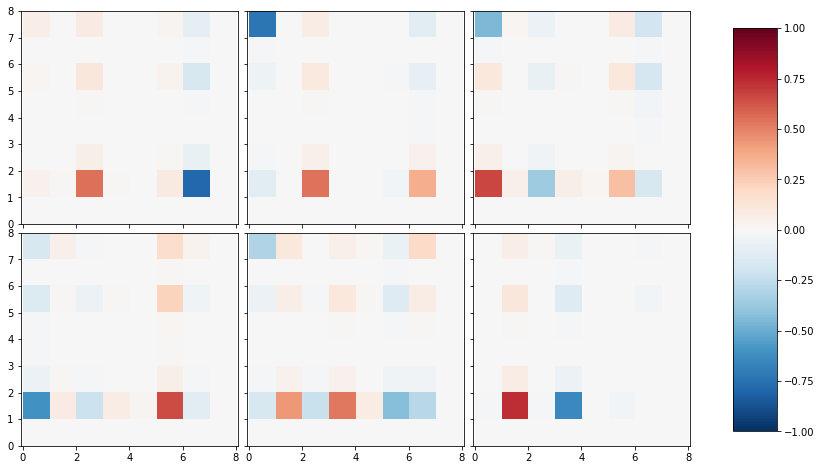

In [44]:
fig, axes = plt.subplots(2,3, sharex = True, sharey = True, gridspec_kw = {'hspace' : 0.04, 'wspace' : 0.04})
fig.set_size_inches(12,8)
for ax, comp in zip(axes.flat, pca.components_[keep_idcs]):
    ax.set_xlim((0,8))
    ax.set_ylim((0,8))
    im = ax.imshow(comp.reshape(8,8), cmap = 'RdBu_r', vmin=-1, vmax=1, extent = [0,8,0,8])

fig.subplots_adjust(right = 0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax = cbar_ax)
plt.show()

Add blurb

#### Clustering

It would be interesting to see whether there are clusters formed around certain reciprocity clusters. To this end Dirichlet clustering is invoked (I do not like k-means). First of all, a dissimilarity measure is needed. Taking the $L_{2}$ overlap of  the reciprocity distributions can be misleading. For example, consider the following three distributions below:

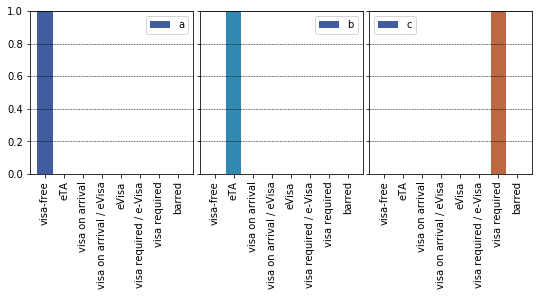

In [45]:
fig, axes = plt.subplots(1,3, sharex = True, sharey = True, gridspec_kw = {'wspace' : 0.04, 'hspace' : 0.04})
fig.set_size_inches(9,3)
for idx, ax in enumerate(axes.flat):
    if idx == 0:
        ax.bar(range(nc), [1,0,0,0,0,0,0,0], color = cat_colors, label = 'a')
    elif idx == 1:
        ax.bar(range(nc), [0,1,0,0,0,0,0,0], color = cat_colors, label = 'b')   
    elif idx == 2:
        ax.bar(range(nc), [0,0,0,0,0,0,1,0], color = cat_colors, label = 'c')
    
    ax.set_ylim((0,1))
    ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
#
    ax.set_xticks(range(nc))
    ax.set_xticklabels(category_lookup.values(), rotation = 90)
    ax.legend()
plt.show()

The $L_{p}$ distances between any two distributions are equal. However, we feel that **(a)** is closer to **(b)** than  to **(c)** for _visa free_ is closer to _ETA_ than to _visa required_. In general, when comparing probability distributions over ordered categorical variables it is advantageous to use a distance that represets the underlying ordering. One such function is the [_earth mover's distance_](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/rubner-jcviu-00.pdf) (EMD) or [_Wasserstein metric_](https://en.wikipedia.org/wiki/Wasserstein_metric). It is the minimum work required to move one distribution to match and other one, in a nutshell. Before we calculate EMDs for the countries two notes are in order:

* The two dimensional nature of the reciprocity matrix is taken into account by generating a 2D ground distance matrix. For the details please see `calc_ground_distance_2d` in the appendix. 
* The hiearchical clustering matches pairs of distributions with gradually increasing $L_{2}$ distance. As a consequence, the above effect is mitigated to some extent, for the widely dissimilar vectors are unlikely to be paired.

The ground distance matrix is calculated:

In [46]:
def calc_ground_distance_2D(N):
    """
    Calculates the 2D Manhattan distance for a N*N grid. It returns the flattened 2D distance matrix
    d(ij,kl) = |i - j| + |k - l| (4D)
    Let: m = i * N + j and n = k * N + l
    Let D \in N^{n^2, n^2}
    Then D(n,m) = d(n//N, mod(n,N), m//N, mod(m,N)) = d(ij, kl)
    Parameters:
        N (int) : gridsize
    Returns:
        dmat (np.ndarray[:,:] dtype = np.int) : the flattened Manhattan distance matrix
    """
    
    i_arr = np.repeat(np.arange(N, dtype = np.int), N)
    j_arr = np.tile(np.arange(N, dtype = np.int), N)
    
    dmat = np.abs(np.subtract.outer(i_arr,i_arr)) + np.abs(np.subtract.outer(j_arr, j_arr))
    
    return dmat   

In [47]:
d_ground = calc_ground_distance_2D(8)

The matrix below is the ground distance between two flattened reciprocity matrix. The $(m,n)$-th element is the $L_{1}$ distance between

$$
\big(i \leftarrow \lfloor \frac{m} {n_{c}} \rfloor, j \leftarrow \text{mod}(m, n_{c})\big) \text{ and } \big(k \leftarrow \lfloor \frac{n} {n_{c}} \rfloor, l \leftarrow \text{mod}(n, n_{c})\big)
$$

C:\Users\Balazs\Anaconda3\lib\site-packages\matplotlib\colorbar.py:218: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


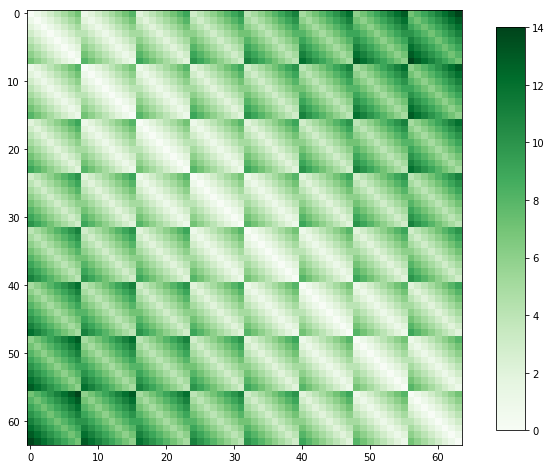

In [48]:
fig, ax  = plt.subplots(1,1)
fig.set_size_inches((8,8))
im = ax.imshow(d_ground, interpolation = None, cmap = 'Greens', vmin = 0.0, vmax = 14)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax = cbar_ax)
plt.xticks([0,8,16,24,32,40,48,56], ['(0,0)', '(1,0)', '(2,0)', '(3,0)', '(4,0)', '(5,0)', '(6,0)', '(7,0)'])
plt.show()

We can now calculate the EMD, `emd` for all pairs of countries using the [`Python Optimal Transport` module](http://pot.readthedocs.io/en/stable/index.html). We also determine the Euclidean distance, `l2d`.

In [49]:
import ot
emd = ssd.squareform(ssd.pdist(cnt_recip_mat, lambda x, y: ot.emd2(x, y, d_ground)))
l2d = ssd.squareform(ssd.pdist(cnt_recip_mat))

It is readily seen from the joint plot below that the earth mover's distance is usually larger than the ordinary $L_{2}$ distance. This is due to taking the distance between the ordered categories into account. 

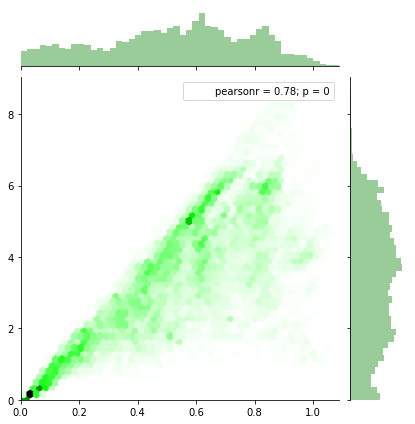

In [50]:
ax = sns.jointplot(np.ravel(l2d), np.ravel(emd), kind = 'hex', color = 'green')
ax.x= np.linspace(0,1); ax.y = np.linspace(0,1);
plt.show()

boooo

In [51]:
Z_emd = linkage(emd, 'ward') 
Z_l2d = linkage(l2d, 'ward')

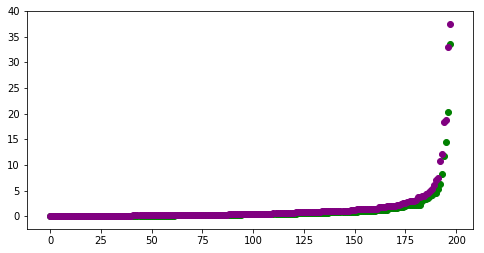

In [52]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(8,4)
axes.scatter(range(ng-1), Z_emd[:,2] / 10, color = 'green')
axes.scatter(range(ng-1), Z_l2d[:,2], color = 'purple')
plt.show()

We then compare the labels at various cuts.

In [53]:
from sklearn.metrics import fowlkes_mallows_score

In [54]:
label_pairs = ((linkage_to_labels(Z_emd, n), linkage_to_labels(Z_l2d, n)) for n in range(1,10))
scores = list(fowlkes_mallows_score(*lp) for lp in label_pairs)

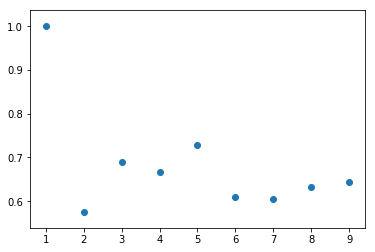

In [55]:
plt.scatter(range(1,10), scores)
plt.show()

### Asymmetry 

In [56]:
label_map = dict(zip(requirement_order_map.values(), requirement_order_map.keys()))
label_map.pop(-1, None)

p_recip_mat = recip_mat / np.sum(recip_mat, axis = 0)

cat_labels = list(requirement_order_map.keys())[1:]
fig, axes = plt.subplots(2,4, sharex = True, sharey = True)
fig.set_size_inches(12,6)

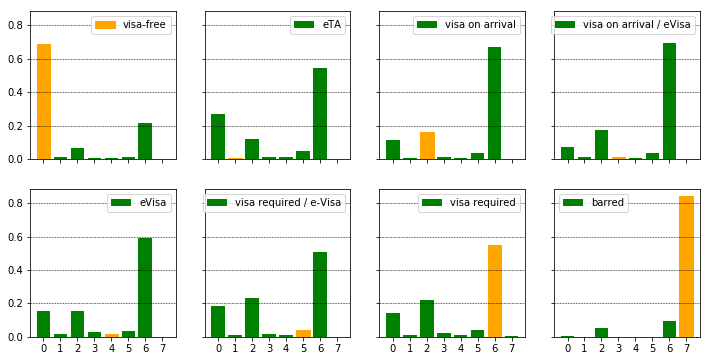

In [57]:
for idx, (col, ax) in enumerate(zip(p_recip_mat.T, axes.flat)):
    ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)

    plt.xticks(range(8), range(8))
    blist = ax.bar(range(len(col)), col, label = label_map[idx], color = 'green')
    blist[idx].set_color('orange')
    
    ax.legend()
plt.show()

The probabilities of the reverse entry requirements are the normalised column entries.

From these probability plots one can deduce that _visa free_ and _visa required_ requirements are mostly reciprocated ($p_{0,0}= 0.7, p_{7,7} = 0.55$). Countries also tend to mutally bar each other's citizen's ($p_{8,8} = 0.95$). At least there is something they agree on. 

To see much a country's entry requirements reciprocated the overlap between its the host $v_{i,*}$ and guest $v_{*,i}$ vectors is calculated.

$$
A_{us}(i) = \frac{\sum\limits_{k} \delta(v_{ik},v_{ki})}{n_{g}}
$$

A more sophisticated indicator is the count the sing of the differences, $A_{sg}$. Negative values are assigned to counries that are more welcoming than welcomed.

$$
A_{sg} = \frac{\sum\limits_{k} \text{sign}(v_{ik} - v_{ki}) } {n_{g}}
$$

A third measure of asymetry is the signed sum of differences, $A_{ss}$. However, the assignment of the actual numerical values to the categories, apart from being ordered, is somewhat accidental.

$$
A_{ss} = \frac{\sum\limits_{k} v_{ik} - v_{ki} } {n_{g}}
$$

In [58]:
# A_{us} -- unsigned overlap
a_unsigned = np.fromiter((np.sum(g == h) for g, h in zip(V, V.T)), count = ng, dtype = np.float) / ng
# A_{sg} -- signed difference
a_signed = np.fromiter((np.sum(np.sign(h - g)) for h, g in zip(V, V.T)), count = ng, dtype = np.float) / ng
# A_{ss} -- sum of signed difference
a_signed_sum = np.fromiter((np.sum(h - g) for h, g in zip(V, V.T)), count = ng, dtype = np.float) / ng / 7

labels = ['unsigned', 'signed', 'signed sum']
df_asym = pd.DataFrame(dict(zip(labels, (a_unsigned, a_signed, a_signed_sum))), 
                       index = df_visa_clean.index)

The three most welcomed country:

In [59]:
df_asym.nsmallest(3, columns = 'signed')

,signed,signed sum,unsigned
US,-0.814070,-0.465901,0.185930
CA,-0.768844,-0.422828,0.201005
AU,-0.572864,-0.346734,0.035176


The three least welcomed countries:

In [60]:
df_asym.nlargest(3, columns = 'signed' , keep = 'last')

,signed,signed sum,unsigned
HT,0.869347,0.638909,0.120603
CI,0.824121,0.519024,0.115578
SO,0.788945,0.463029,0.110553


The flatter regions of the curves below indicate that numerious countries have similar asymetric relations. However, looking at just $A_{us}$ and $A_{sg}$ does tell us whether the asymmetries of different signs compensate each other or a country has symmetric relationships...

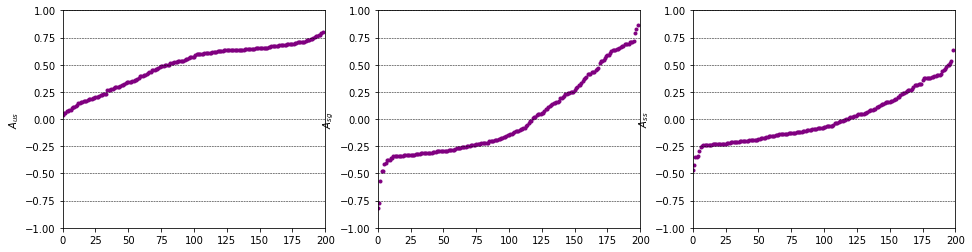

In [61]:
ylabels = dict(zip(labels, [r'$A_{us}$', r'$A_{sg}$', r'$A_{ss}$']))
                  
fig, axes = plt.subplots(1,3, subplot_kw = {'ylim' : (-1.0, 1.0), 'xlim' : (0.0, 200.0)} , figsize = (16,4))

for label, ax in zip(labels, axes):
    ax.scatter(range(ng), np.sort(df_asym[label].values), marker = '.', c = 'purple')
    ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
    ax.set_ylabel(ylabels[label])
plt.show()

... A joint plot of the two distributions can resolve this issue: countries tend not to have symmetric relations around half of the time. Moreover the kde plot of the $y$-axis shows that countries are tend to me more sought after than welcoming. 

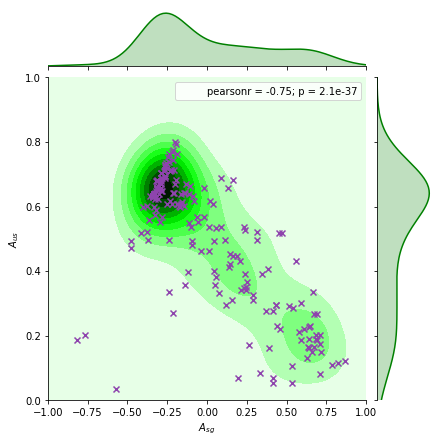

In [62]:
ax = sns.jointplot(a_signed, a_unsigned, kind = 'kde', color = 'green', xlim = (-1, 1.0), ylim = (0.0, 1.0))
ax.x = a_signed; ax.y = a_unsigned;
ax.set_axis_labels(r'$A_{sg}$', r'$A_{us}$')
ax.plot_joint(plt.scatter, marker = 'x', c = '#8E44AD')
plt.show()

$$
\begin{eqnarray}
r & = & 1 - A_{us} \\
\phi & = & A_{sg} \cdot \frac{\pi}{2}
\end{eqnarray}
$$

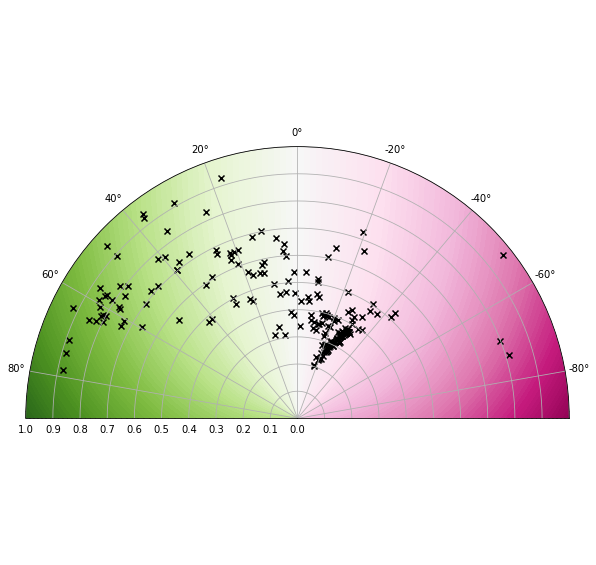

In [63]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='polar', rmax = 1.0)
ax.set_rlim()
ax.set_thetalim((np.pi/2, -np.pi/2))
ax.set_theta_zero_location("N")
ax.set_yticks(np.linspace(0, 1, num = 11))

y = np.linspace(0, 1.0, num = 150)
x = np.linspace(-np.pi/2, np.pi/2, num = 150)
z = np.outer(np.exp(y), x)

ax.contourf(x, y, z, 150, cmap = plt.get_cmap('PiYG'))
ax.scatter(a_signed * np.pi / 2 , 1.0 - a_unsigned, facecolor = 'black', marker = 'x')

plt.show()

### Blocks


It is interesting to see whether there are groups of countries which have stronger ties among themselves than with others. An extreme example is a group where all entry requirements are _visa free_ in both directions.

To this end consider the directted graph where the vertices are the countries; each of them connected by two directed edges corresponding to the entry requirements. We then color the edges according to their types _e.g._ Holy See and Italy are connected by two antiparallel _blue_ edges. Finding a group of identical entry requirements is then equvalent to finding the n-cliques containing only edges of the same colour.

This can be done in the following way:

$$ \begin{eqnarray} & & \textbf{Algorithm:} \textit{Find maximum disjoint coloured cliques} \\
&. & \quad \texttt{FMDCC}(G, c) \\
&. & \quad G' \leftarrow \left(V, G(E)  \setminus \{v_{ij} \in G(E): \,\, 
\texttt{Colour}(v_{ij}) \neq \texttt{Colour}(v_{ji}) \} \right) \\ 
&. & \quad G' \leftarrow \left(V, G(E)  \setminus \{v_{ij} \in G(E): \,\, 
 \texttt{Colour}(v_{ij}) \neq c\} \right) \\ 
&. & \quad \mathbf{Blocks} \leftarrow () \\
&. & \quad \mathbb{S} \leftarrow \texttt{FindDisjointSubgraphs}(G') \\
&. & \quad \textbf{for} \,S \in \mathbb{S}  \textbf{ do} \\
&. &  \quad \quad \textbf{while} \, |S| > 0 \, \textbf{do} \\
&. & \quad \quad \quad  C \leftarrow \texttt{FindMaximumClique}(S) \\
&. & \quad \quad \quad \mathbf{Blocks}.append( C)  \\ 
&. & \quad \quad \quad S \leftarrow S \setminus C \\ 
&. & \quad \quad \textbf{end while} \\ 
&. & \quad \textbf{end do} \\ 
\end{eqnarray} $$

In [64]:
# === T O  H I D E
import networkx as nx

def find_colour_max_cliques(X, colour):
    """
    Finds the maximum disjoint cliques with edges of identical colour in a graph.
    Parameters:
        A (np.ndarray) : adjacency matrix containing the colours for each edges
        colour (int) : index of the colour. Be careful when using 0 as colour index!
    Returns:
        max_cliques ([[int]]) : list of node indices in the maximum cliques
    """
    # choose colour
    colour = colour # visa free

    # Create adjacency matrix, connected (True) if entry and exit requirements are identical
    A = (X == colour) & ((X - X.T) == 0)

    # generate a graph
    G = nx.from_numpy_matrix(A)

    # find disjoint subgraphs
    groups =(G.subgraph(c).copy() for c in nx.connected_components(G))

    # remove singleton clusters
    groups  = filter(lambda x: x.order() > 1, groups)

    max_cliques = []
    
    for group in groups:
        # find maximum clique and remove  
        # this is really inefficient...
        while group.order() > 0:
            cliques = list(nx.find_cliques(group))
            cliques.sort(key = len)                  # find maximum clique 
     
            if len(cliques[-1]) > 1:                 # ignore singletion cliques  
                max_cliques.append(cliques[-1])
                
            group.remove_nodes_from(cliques[-1])     # remove maximum clique
                  
    return max_cliques

In [65]:
# === T O  H I D E
def _bezier(pos_start, post_end, pos_control, n_points):
    """
    Calculates the quadratic Bezier curve given the points.
    """
    t = np.linspace(0, 1, num = n_points)[:,None]
    s = (1.0 - t)  
    pos = s * (s * pos_start + t * pos_control) + t * (s * pos_control + t * post_end)
    pos = pos.T

    return pos

def _set_circle_positions(start_angle, n_points):
    """
    Calculates the coordinates of a given number of points on the unit circle
    Parameters:
        n_points (int) : number of points
    Returns
        pos (np.ndarray (2, npoints), np.float) : positions of the points.
    """

    angles = np.linspace(start_angle, start_angle + np.pi * 2, num = n_points, endpoint = False)
    pos = np.vstack([np.cos(angles), np.sin(angles)]).T

    return pos

def _set_control_pos(pos_start, pos_end, pos_centre = np.zeros(2, dtype = np.float), scale = 1.0):
    """
    Sets the control point of a quadratic Bezier curve.
    Parameters:
        pos_start (np.ndarray[]) : starting point of the Bezier curve
        pos_end (np.ndarray[]) : end point of the Bezier curve
        pos_centre (np.ndarray[]) : reference point
        scale (float) : sets radius of the arc. 0.0: straight line, R, 1.0: R_{circ}. Default 1.0.
    Returns:
        pos_control (np.ndarray[]) : control point of the Bezier curve
    """
    _mid = (pos_start + pos_end) * 0.50
    pos_control = scale * pos_centre + (1.0 - scale) * _mid 

    return pos_control

class CircoPlot(object):
    
    def __init__(self, n, ax = None, labels = None, start = 0):
        
        if ax is None:
            fig, ax = plt.subplots(1,1)
            self._ax = ax
        else:
            self._ax = ax
        
        self._edges = []   
        self._labels = labels    
        self._n = n 
        self._start = start * np.pi / 180
                    
        self._node_positions = _set_circle_positions(self.start, self.n)
        
    @property
    def ax(self):
        return self._ax
    
    @property
    def n(self):
        return self._n

    @property
    def start(self):
        return self._start
        
    def add_edges(self, edges, colours):
        # whatever         
        self._edges.extend(list(zip(edges, colours)))
        
    def draw(self):
        # --- create Bezier curves for all edges
        
        self._ax.scatter(self._node_positions[:,0], self._node_positions[:,1], 
                    marker = 'o', 
                    color = 'black', 
                    facecolors = 'none')   
        
        for (_is, _it), colour in self._edges:
            if _is == _it: continue
                
            pos_start, pos_end = self._node_positions[_is], self._node_positions[_it]
            pos_control = _set_control_pos(pos_start, pos_end, scale = 0.5)
            arc = _bezier(pos_start, pos_end, pos_control, 50)
            # plot arc
            self._ax.plot(arc[0], arc[1], color = colour, linewidth = 0.2)  
         
        # add labels
        if labels is not None:
            
            label_positions = self._node_positions * (1.05)
            label_angles = (np.arange(self.n, dtype = np.int) / self.n) * 360
         
            for idx, label in labels.items():
                x, y = label_positions[idx]
                angle = label_angles[idx]
                    
                ax.text(x, y, label, rotation = angle,  rotation_mode="anchor", color = 'blue')

(To generate the plots below a fair of amount modestly interesting code is required. All of the functions can be found in the raw jupyter notebook.)

In [66]:
# === T O  H I D E
from itertools import chain, count, islice, product

# returns a list of the list lengths of a nested list
get_list_lengths = lambda x: list(map(lambda y: len(y), x))

# generates consecutive integer lists
generate_consecutive_lists = lambda x, y = count(): list(map(lambda x: list(islice(y, x)), x))

# generates a list of list limits
get_list_limits = lambda x: map(lambda y: (y[0], y[-1] + 1), x)

# generates corner indices for a block
get_corner_idcs = lambda x:  product((x), (x))

# flatten nested lists
flatten_lists = lambda x: list(chain(*x))

The cliques of _visa free_ countries, `cliques_vf` are retrieved as:

In [67]:
cliques_vf = find_colour_max_cliques(V,0)

The blocks are then printed on a circular layout where each node correspond to a country, and each edge is a mutual _visa free_ requirement.

In [68]:
# increasing indices for blocks
idcs = generate_consecutive_lists(get_list_lengths(cliques_vf), count())
# all edges in every block
vf_all_edges = list(chain(*map(lambda x: list(product(x,x)), idcs)))

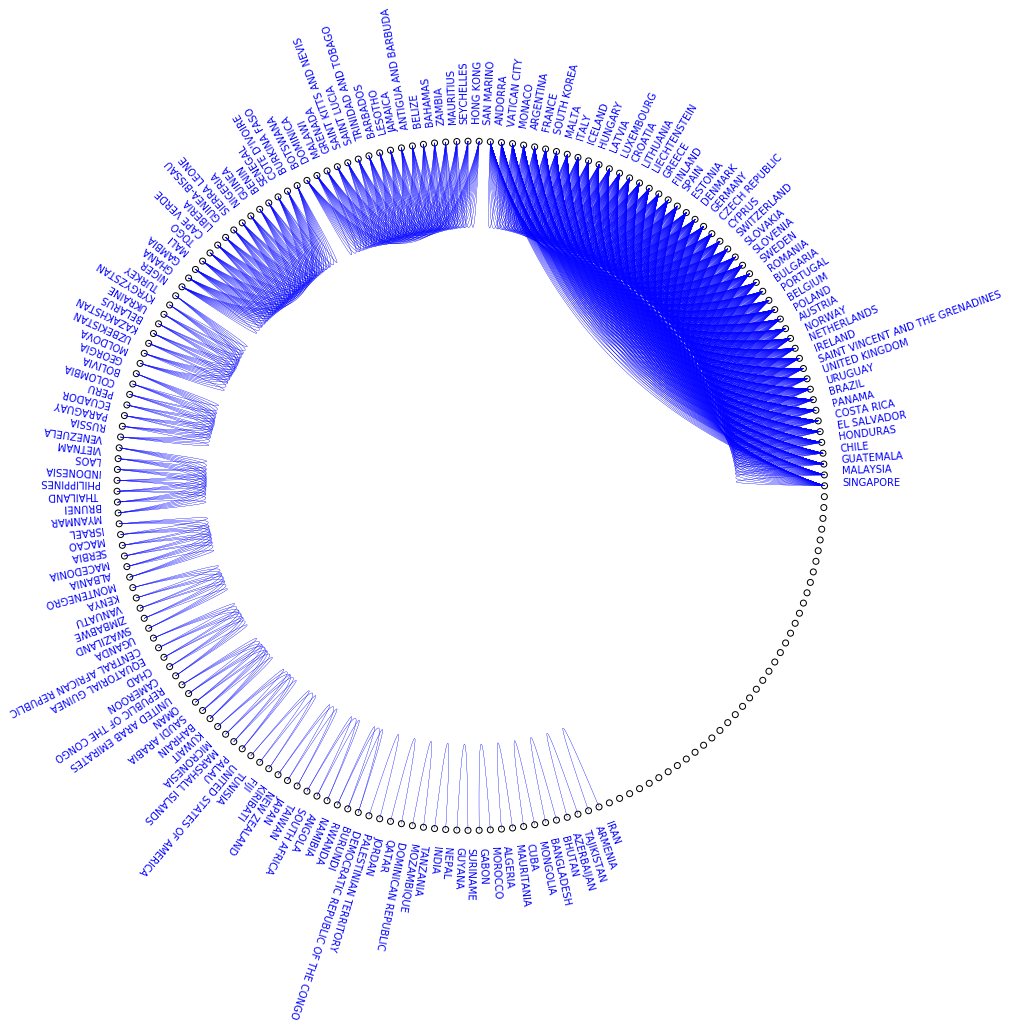

In [69]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(14,14)
ax.axis('off')

labels = [cnt_name_lookup[idx] for idx in flatten_lists(cliques_vf)]
labels = dict(enumerate(labels))

cp = CircoPlot(ng, ax = ax, labels = labels)

cp.add_edges(vf_all_edges, ['blue']*len(vf_all_edges))
cp.draw()
plt.show()

In [70]:
# === T O  H I D E

# block member indices
idcs = np.array(flatten_lists(cliques_vf), dtype = np.int)

# 0. matrix with block lines
raw_idcs = sorted(idcs)
Vsel = V[raw_idcs][:,raw_idcs]
Vsel[Vsel < 0] = 0
# 1. permute countries in to block structure
# permutation (please note it is really memory inefficient)
bm_vf = V[idcs][:, idcs]
bm_vf[bm_vf < 0] = 0          # cosmetics :-(

# 2. sort off block entries for better appearance
# block indices [0, 0, ..., 0, 1, 1, ..., 1, ..., n_block -1, ..., n_block - 1]
idcs = np.repeat(np.arange(len(cliques_vf)), get_list_lengths(cliques_vf))

# get column means by blocks
col_means = np.mean(bm_vf[idcs], axis = 1)

# get array that sorts matrix by block index and column mean
idcs = np.lexsort((col_means, idcs))

# permute block matrix so that the off block colours are arranged 
bm_st_vf = bm_vf[idcs][:,idcs]

In [71]:
# === T O  H I D E
# find out the indices of the block in the new matrix
n_clique_sizes = get_list_lengths(cliques_vf)
idcs = generate_consecutive_lists(n_clique_sizes, count())
c_idcs = get_corner_idcs(list(get_list_limits(idcs)))

# replace block values by mode
bm_mo_vf = np.zeros_like(bm_vf)

for (tr, lr), (tc, lc) in c_idcs:
    bm_mo_vf[tr:lr,tc:lc] = most_common(bm_vf[tr:lr,tc:lc].flat)

In [72]:
# === T O  H I D E
# multiplex
# @TODO add axis specifications and multiple factors
def multiplex(mat, factor = 2):
    """
    Multiplexes a np.ndarray
    Parameters:
        mat (np.ndarray) : at least 2D array
        factor (np.int) : multiplex factor
    Returns:
        mat_new (np.ndarray) : multiplexed matrix
    Examaple:
    a.shape = (n, n) --> b.shape = (factor * n, factor * n)  
    """    
    new_mat = np.repeat(np.repeat(mat, factor, axis = -2), factor, axis = -1)
    
    return new_mat 

In [73]:
# === T O  H I D E
def add_borders(mat, border_positions, border_value, copy = True):
    """
    Add 'borders' to an array at certain values.
    Parameters:
        mat (np.ndarray) : at least 2D array
        border_positions (n) : multiplex factor
    Returns:
        mat_new (np.ndarray) : multiplexed matrix 
    """
    if copy:
        new_mat = np.copy(mat)
    else:
        new_mat = mat
        
    new_mat[border_positions,:] = new_mat[:,border_positions] = border_value
    
    return new_mat

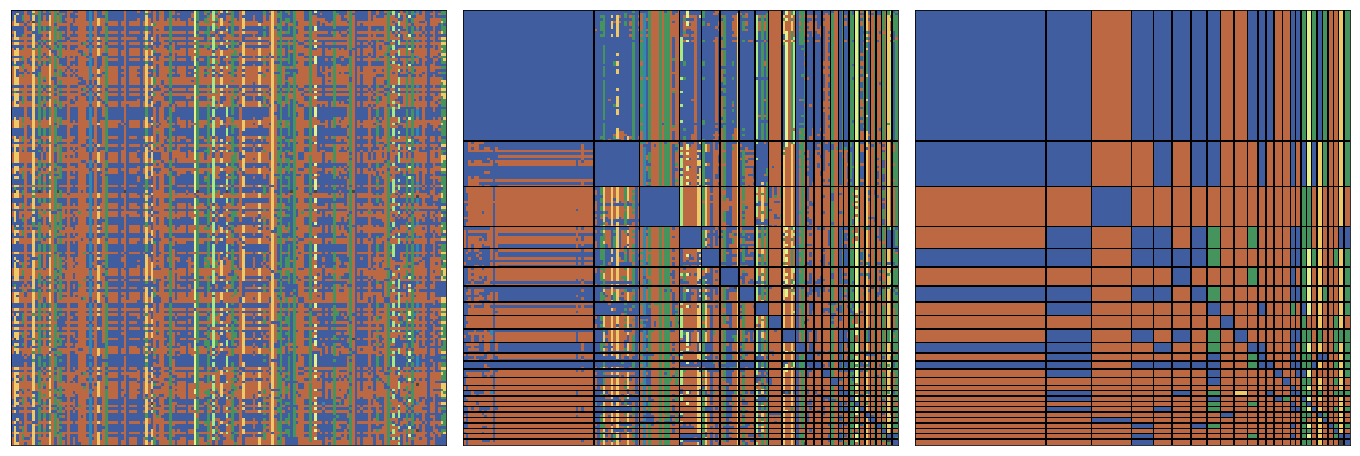

In [74]:
# bm_vf, bm_mo_vf, bm_sm_vf

factor = 2
idcs = generate_consecutive_lists(n_clique_sizes, count())
border_positions = [(x[-1] + 1) * factor - 1 for x in idcs[:-1]] 

matrices = (multiplex(Vsel, factor = factor),
            add_borders(multiplex(bm_st_vf, factor = factor), border_positions, -1),
            add_borders(multiplex(bm_mo_vf, factor = factor), border_positions, -1))


fig, axes = plt.subplots(1,3, sharey = True, gridspec_kw = {'wspace' : 0.04})
fig.set_size_inches(24,24)
cmaps = (cat_cmap, cat_cmap_aug, cat_cmap_aug)

for ax, matrix, cmap in zip(axes, matrices, cmaps): 
    ax.set_adjustable('box-forced')
    ax.imshow(matrix, cmap = cmap)
    ax.set_xticks([], [])
    ax.set_yticks([], [])
plt.show()

### Requirement similarity

Finally, we compare countries by their country specific requirements. Again, we start with defining a distance. The most striaghtforward choice is the simple matching coefficient, $d_{smc}$ excluding the host and guest countries:

$$
d_{smc}(ij) = \sum\limits_{k\notin \{i,j\}} \delta ( v_{ik}, v_{jk}) \, .
$$

This, however, is not a proper metric and does not take into account the ordering of the categories. The second choice can be the $L_{1}$ distance, again excluding the host and gues countries:

$$
d_{L1} = \sum\limits_{k\notin \{i,j\}} | v_{ik} - v_{jk} | \, .
$$

The drawback of this one, that the numerical values of the ordinal categories are arbitrary. One can use the Jaccard distance over the sets of tuples:

$$
d_{Jac} = \frac{S_{i} \cap S_{j} }   { S_{i} \cup S_{j} }\,\, \text{where }  S_{k} = \{(k, v_{kl}) \},\,\, k\neq l
$$

We will use the $L_{1}$ distance, for it reflects the ordering of the categories.

In [ ]:
def maksed_l1(v1, v2):
    
    """
    
    """
    mask = (v1 != -1)  & (v2 != -1)
    l1 = np.sum(np.abs(v1[mask] - v2[mask]))
    return l1